<a href="https://colab.research.google.com/github/alexandrufiruti/fuzzypeergroups/blob/master/mlav/face_landmark_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Proiect MLAV** -  Face (Eye) Landmarks localization
*   Baza de date: Caltech 10k Web Faces ([aici](http://www.vision.caltech.edu/Image_Datasets/Caltech_10K_WebFaces/))
*   Arhitectura : ResNet-18 (detalii [aici](https://www.youtube.com/watch?v=**ZILIbUvp5lk**))



Accesare date (daca nu exista deja local):


1.   Descarcare arhiva cu *wget*
2.   Dezarhivare
3.   Stergere arhiva dupa dezarhivare



In [1]:
import os

# descarcare imagini
!rm -r *
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_2.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_3.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_4.zip
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_5.zip
!unzip '*.zip' 1>/dev/null
!mkdir all_helen
!mv helen_*/* all_helen/
!rm -r helen_*
!echo "Numarul total de imagini (antrenare & testare):"
!ls all_helen | wc -l

# descarcare adnotari
!wget http://www.ifp.illinois.edu/~vuongle2/helen/data/annotation.zip
!unzip 'annotation.zip' 1>/dev/null
!rm -r annotation.zip
!ls annotation | wc -l



--2020-11-07 16:16:41--  http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_1.zip
Resolving www.ifp.illinois.edu (www.ifp.illinois.edu)... 130.126.122.239
Connecting to www.ifp.illinois.edu (www.ifp.illinois.edu)|130.126.122.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96876123 (92M) [application/zip]
Saving to: ‘helen_1.zip’

helen_1.zip         100%[===================>]  92.39M  56.1MB/s    in 1.6s    

2020-11-07 16:16:43 (56.1 MB/s) - ‘helen_1.zip’ saved [96876123/96876123]

--2020-11-07 16:16:43--  http://www.ifp.illinois.edu/~vuongle2/helen/data/helen_2.zip
Resolving www.ifp.illinois.edu (www.ifp.illinois.edu)... 130.126.122.239
Connecting to www.ifp.illinois.edu (www.ifp.illinois.edu)|130.126.122.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106113055 (101M) [application/zip]
Saving to: ‘helen_2.zip’

helen_2.zip         100%[===================>] 101.20M  56.1MB/s    in 1.8s    

2020-11-07 16:16:45 (56.1 MB/s)

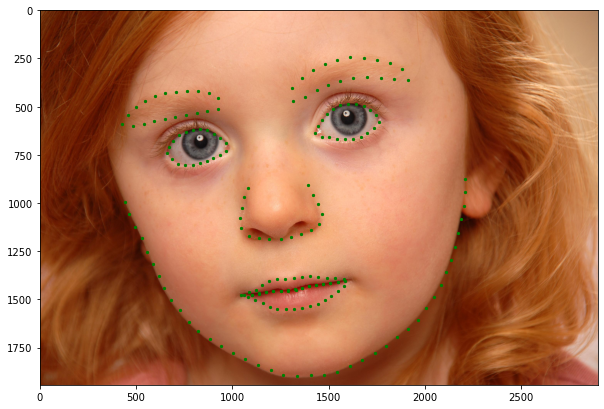

In [2]:
from skimage import io
import matplotlib.pyplot as plt
from math import floor
import numpy as np

landmark_dict = dict() # dictionar {key=nume_fisier, value=lista_puncte_landmark}
for filename in os.listdir('annotation'):
  with open("annotation/"+filename, 'r') as f:
    imagename = f.readline().rstrip('\n')
    content = f.readlines()
    points = []
    for point in content:
      temp = (point[:-1].split(" , "))
      points.append([floor(float(temp[0])), floor(float(temp[1]))])
    landmark_dict[imagename] = points
    

#images_dict = dict() # dictionar {key=nume_fisier, value=imaginea}
#for filename in os.listdir('all_helen'):
#  images_dict[filename[:-4]] = io.imread("all_helen/"+filename)# nume fara extensia .jpg

point = landmark_dict['3247810519_1']
point = np.array(point)

img = io.imread("all_helen/3247810519_1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(point[:,0], point[:,1], s = 5, c = 'g')
plt.show()





In [7]:
!pip install mtcnn

# sursa: https://github.com/ipazc/mtcnn

     |████████████████████████████████| 2.3MB 3.4MB/s 


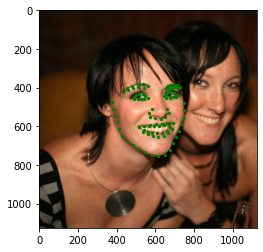

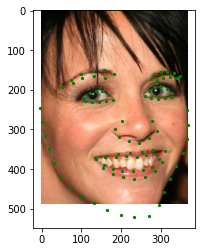

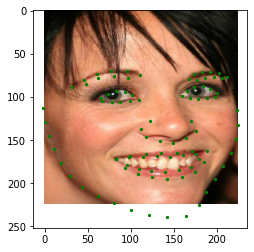

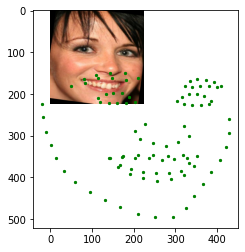

In [59]:
from mtcnn import MTCNN
import cv2
import random
import imutils
from PIL import Image
from math import cos, sin, radians

cropped_image_size = 224
filename = '129408727_1'
angle_range = 10

# printare imagine si landmark suprapus
def print_face_and_landmark(img, landmark):
  plt.imshow(img)
  plt.scatter(landmark[:,0], landmark[:,1], s = 5, c = 'g')
  plt.show()

# detectare fata prin MTCNN (Multi-task Cascaded Convolutional Networks)
def detect_face(img):
  detector = MTCNN()
  return detector.detect_faces(img)[0]['box']

# crop imagine si actualizare landmark
def crop_face(img, landmarks, x, y, w, h):
  cropped = img[y:y+h, x:x+w]
  # landmark-ul doar se translateaza cu x,y stabilite
  landmarks_cropped = landmarks - [x,y]
  return cropped, landmarks_cropped

# modificarea dimensiune imagine si actualizare landmark
def resize_image(img, landmarks, w, h):
  cropped_resized = cv2.resize(img,(cropped_image_size, cropped_image_size))
  landmarks_cropped_resized = landmarks*[cropped_image_size/w,cropped_image_size/h]
  return cropped_resized, landmarks_cropped_resized

# rotire imagine (cu un numar aleatoriu de grade) si actualizare landmark
def rotate_image(img, landmarks):
  angle = random.uniform(-angle_range, +angle_range)
  np_image = imutils.rotate(np.array(img), angle)

  # matrice de rotatie (https://en.wikipedia.org/wiki/Rotation_matrix)
  transformation_matrix = np.array([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
            ])
  landmarks_rotated = np.matmul(landmarks, transformation_matrix)
  landmarks_rotated = landmarks_rotated + np.dot(landmarks_rotated, np.transpose(transformation_matrix))

  return Image.fromarray(np_image), landmarks_rotated

##### PART I - START
# Code de test: pentru a vizualiza operatiile de transformarea pentru o imagine
img = cv2.cvtColor(cv2.imread("all_helen/"+filename+".jpg"), cv2.COLOR_BGR2RGB)
landmarks = np.array(landmark_dict[filename])
landmarks = landmarks[::2, :] # pentru ca sunt prea multe se elimina jumatate din punctele de landmark  
print_face_and_landmark(img, landmarks)

detector = MTCNN()
[x,y, w, h] = detect_face(img)

cropped_img, landmarks_after_crop = crop_face(img, landmarks, x, y, w, h)
print_face_and_landmark(cropped_img, landmarks_after_crop)

cropped_img_resized, landmarks_after_resize = resize_image(cropped_img, landmarks_after_crop, w, h)
print_face_and_landmark(cropped_img_resized, landmarks_after_resize)

rotated_img, landmarks_after_rotate = rotate_image(cropped_img_resized, landmarks_after_resize)
print_face_and_landmark(rotated_img, landmarks_after_rotate)
##### PART I - STOP